y values (from oscilloscope):  [8.869e-05 1.478e-04 1.665e-04 2.048e-04 2.167e-04]
errors in rotation (from oscilloscope data):  [3.e-06 3.e-06 1.e-06 3.e-06 7.e-07]
percent error for each point:  [3.3825685  2.02976996 0.6006006  1.46484375 0.32302723]
percent error from line fit error:  [3.28030156 1.96840288 1.747327   1.42055637 1.34254705]
percent error from diff from fit value:  [11.81835407  8.19634227  0.1973108   6.74999131  0.38070522]


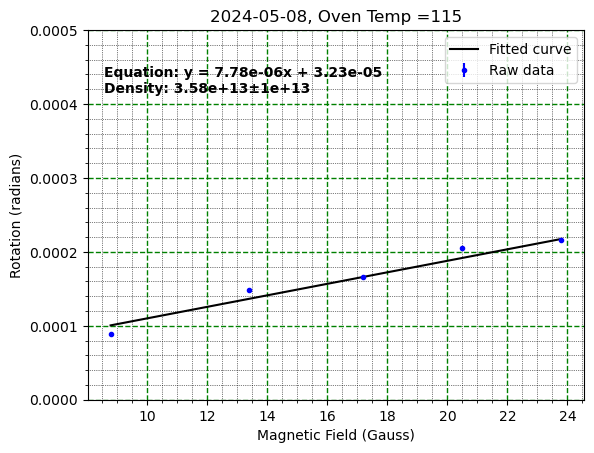

In [5]:
###########################################################################################################
# This module is used to analyze density data sets to obtain a Rb number density
# Specify a date and trial number to retrieve data from the json data files and create a plot 
###########################################################################################################

#import all the things!!!
#real python libraries
import numpy as np
#stuff I wrote
import DataSet as ds
import densityplots as den
import Functions as func
import plotSettings as ps
import Utilities as util
import densityCalculations as calc


#the date I want data for
target_date_d = '08'
target_date_m = '05'
target_date_y = '2024'

#step 1 get the data from the json file
filepath = 'Data/rotationdata_'+target_date_m+target_date_d+target_date_y+'.json'
#collection data in YYYY-MM-DD
target_date = target_date_y+'-'+target_date_m+'-'+target_date_d
trialnum = 16
my_data = util.get_data_from_file(filepath, target_date, trialnum)

#now I have the data. Excellent. Now it needs to be put into a dataSet object
analysis = ds.DataSet(my_data,func.line,'line',100)

#create a subset of data to analyze
subset = analysis.data_subset_index('after',1)
analysis = ds.DataSet(subset, func.line, 'line', 100)

#Estimate slope error form standard dev estimates from covariance matrix
std_dev = analysis.standard_deviation
olen = my_data.optical_length #optical length
laserwl = my_data.laser_wavelength #laser wavelength
density_error = calc.densityError(std_dev[1], olen, laserwl) #the Y variance is the important number here!


#estimate error from error on each data point from oscilloscope averages repotred as percent difference
ys = analysis.get_y_vals()
xs = analysis.get_x_vals()
error_per_point = analysis.get_y_error_vals()
perc_e_point = np.zeros(len(error_per_point)+1)
for i in range(0, len(error_per_point)): 
    perc_e_point[i] = util.percent_error(ys[i], error_per_point[i])
print('y values (from oscilloscope): ', ys)
print('errors in rotation (from oscilloscope data): ', error_per_point)

print('percent error for each point: ', perc_e_point[:len(error_per_point)])
perc_e_curvefit = np.zeros(len(ys)+1)
for i in range(0, len(ys)): 
    perc_e_curvefit[i] = util.percent_error(ys[i], std_dev[1])
print('percent error from line fit error: ', perc_e_curvefit[:len(ys)])


#Estimate error by comparing fit line to collected data point and taking percent difference
fitParam = analysis.getParam()
m = fitParam[0]
b = fitParam[1]

def getFitVal(x):
    val = (m*x)+b
    return val

perc_e_curvecomapre = np.zeros(len(xs)+1)
for i in range(0, len(xs)): 
    y_curve = getFitVal(xs[i])
    dif = y_curve-ys[i]
    perc_e_curvecomapre[i] = util.percent_error(y_curve, dif)
print('percent error from diff from fit value: ', perc_e_curvecomapre[:len(xs)])



#set the plot settings
plot_title = target_date + ', Oven Temp =115'
x_label = 'Magnetic Field (Gauss)'
y_label = 'Rotation (radians)'

vert_min = 0.000
vert_max = 0.0005


#approximate rubidium density so we can display it on the plot
#now with estimated error value!
density_disp_val = str(analysis.rb_density_formatted()) + u"\u00B1" + str(density_error)

#set up the plot
my_settings = ps.plotSettings(plot_title, 
                              x_label , 
                              y_label , 
                              vert_min, 
                              vert_max, 
                              analysis.plotdata, 
                              analysis.fitted_data, 
                              analysis.chisqd, 
                              analysis.equation, 
                              density_disp_val)
#plot the data with the settings specified
den.better_plot(my_settings)
